#  Прогнозирование заказов такси

## Подготовка данных

In [1]:
# установка дополнительных пакетов
!pip install optuna

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna

from scipy.stats import kurtosis
from scipy.signal import find_peaks

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set_theme(style="whitegrid")

SEED=123

In [4]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
# получение общей информации о датасете
def get_info(data):
    display(data.shape)
    display(data.isna().sum())
    display(data.head())
    display(data.info())
    display(data.describe())

In [6]:
get_info(taxi)

(26496, 1)

num_orders    0
dtype: int64

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
# сортировка индекса по хронологическому порядку
taxi = taxi.sort_index()

In [8]:
# проверка на монотонность индекса
taxi.index.is_monotonic

True

In [9]:
# проверка индекса на уникальные значения
taxi.index.is_unique

True

In [10]:
taxi.index.min()

Timestamp('2018-03-01 00:00:00')

In [11]:
taxi.index.max()

Timestamp('2018-08-31 23:50:00')

***Вывод:*** датасет содержит информацию о количестве заказов такси с 1 марта 2018 года по 31 августа 2018 года с интервалом в 10 минут. Пропусков во временном ряде не обнаружено, максимальное количество заказов за исследуемый период составляет 119. Далее выполню ресемплирование по 1 часу и проанализирую временной ряд.

## Анализ временного ряда

### Ресемплирование

In [12]:
# ресемплирование интервала по 1 часу
taxi = taxi.resample('1H').sum()

In [13]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Построю график исходного временного ряда:

<AxesSubplot:xlabel='datetime'>

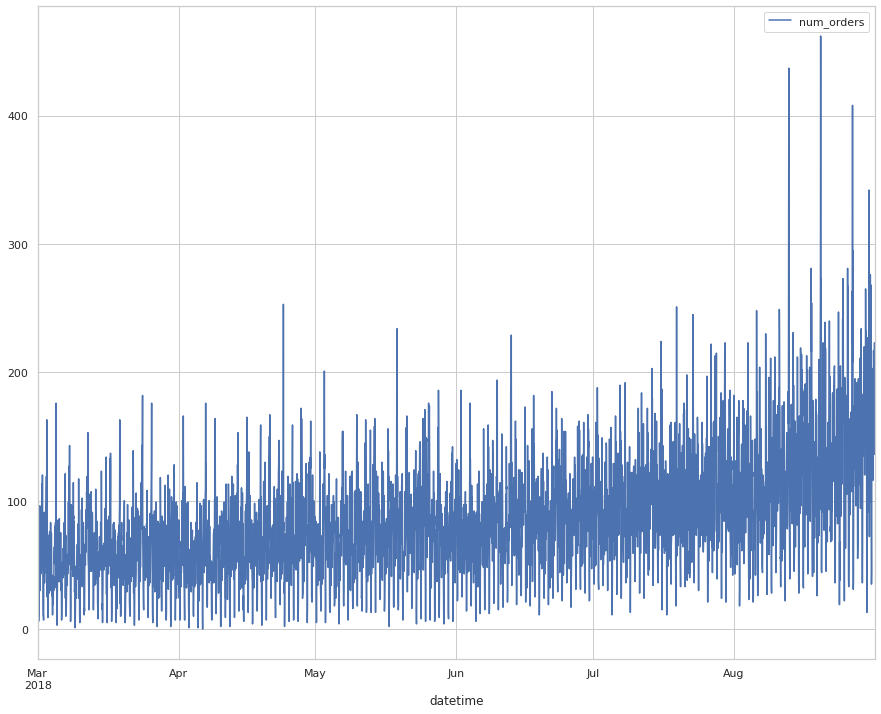

In [14]:
plt.rcParams['figure.figsize'] = [15, 12]
taxi.plot()

### Скользящее среднее значение

Буду использовать скользящее среднее для сглаживания исходного временного ряда. Рассмотрю разные размеры окна для выявления тренда.

In [15]:
def plot_moving_average(
    df, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    rolling_mean = df.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend", alpha=1.0)

    # построение доверительных интервалов для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(df[window:], rolling_mean[window:])
        deviation = np.std(df[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # поиск аномальных значений, выходящих за пределы доверительного интервала
        if plot_anomalies:
            anomalies = pd.DataFrame(index=df.index, columns=df.columns)
            anomalies[df < lower_bond] = df[df < lower_bond]
            anomalies[df > upper_bond] = df[df > upper_bond]
            plt.plot(anomalies, "ro", markersize=6)

    plt.plot(df[window:], label="Actual values", alpha=0.6)
    plt.legend(loc="upper left")
    plt.grid(True)

Сглажу временной ряд по предыдущим суткам:

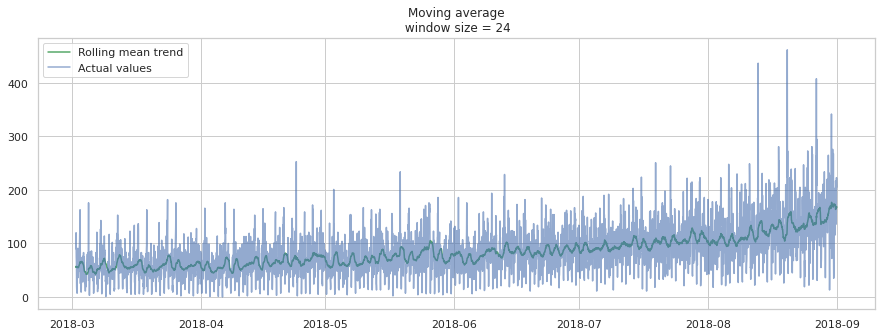

In [16]:
plot_moving_average(taxi, 24)

По предыдущим двум дням:

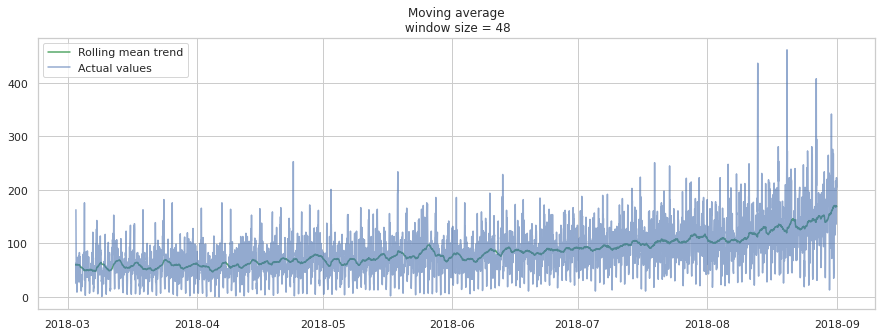

In [17]:
plot_moving_average(taxi, 48)

И по 168 часам, то есть получаю недельный тренд:

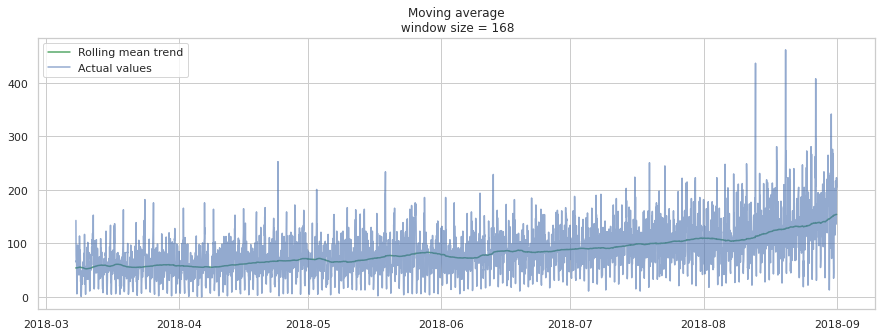

In [18]:
plot_moving_average(taxi, 168)

После применения еженедельного сглаживания наблюдается рост числа заказов такси в течении рассматриваемого полугодового периода. Так же прослеживаются небольшие спады в начале некоторых месяцев, за которыми следует рост числа заказов.

Построю 95% доверительный интервал для сглаженных значений:

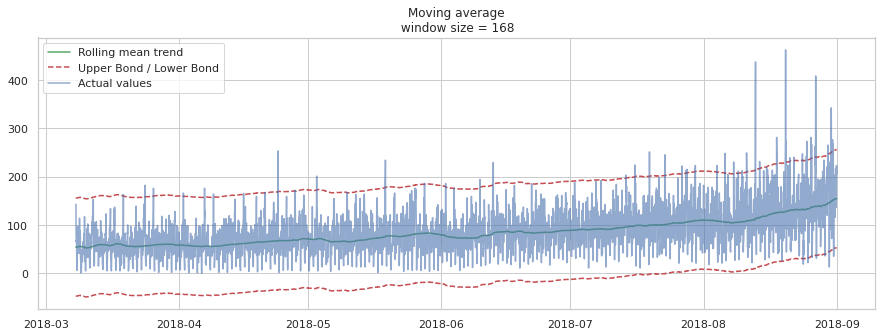

In [19]:
plot_moving_average(taxi, 168, plot_intervals=True)

Отражу на графике значения, выбивающиеся из границ доверительного интервала:

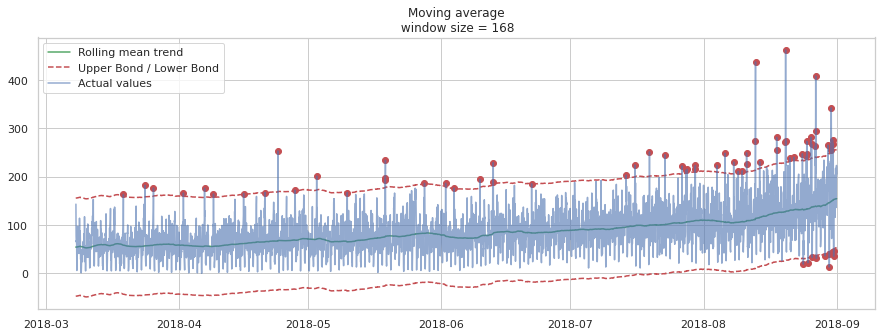

In [20]:
plot_moving_average(taxi, 168, plot_intervals=True, plot_anomalies=True)

Большое количество значений, выходящих за 95% ДИ, явно прослеживаются во второй половине лета - это можно объяснить тем, что в этот период люди чаще и активнее берут отпуска и летают отдыхать - отсюда количество заказов такси в аэропорт может быть больше.

### Экспоненциальное сглаживание

При использовании метода экспоненциального сглаживания взвешиваются все доступные наблюдения, и веса экспоненциально умешаются  по мере продвижения назад во времени.

In [21]:
def exponential_smoothing(series, alpha):

    result = [series.iloc[0]]
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n - 1]) # формула экспоненциального сглаживания
                                                                            # где alpha - коэффициент сглаживания
    return result

Коэффициент `alpha` определяет, насколько быстро забывается последнее доступное истинное наблюдение. Чем меньше `alpha`, тем большее влияние оказывают предыдущие наблюдения и тем более гладким является ряд.

In [22]:
def plotExponentialSmoothing(series, alphas):

    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(
                exponential_smoothing(series, alpha), label="Alpha {}".format(alpha)
            )
        plt.plot(series.values, "c", label="Actual", alpha=0.5)
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

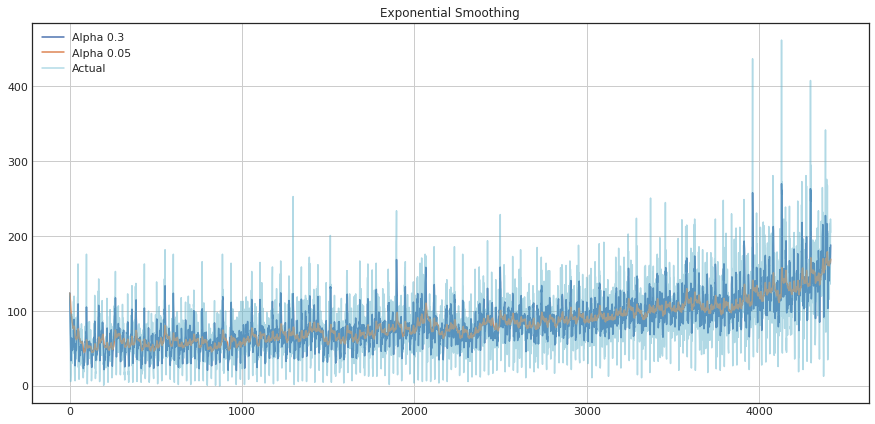

In [23]:
plotExponentialSmoothing(taxi, [0.3, 0.05])

### Тренды и сезонность

In [24]:
plt.rcParams['figure.figsize'] = [15, 12]

In [25]:
decomposed = seasonal_decompose(taxi['num_orders'])

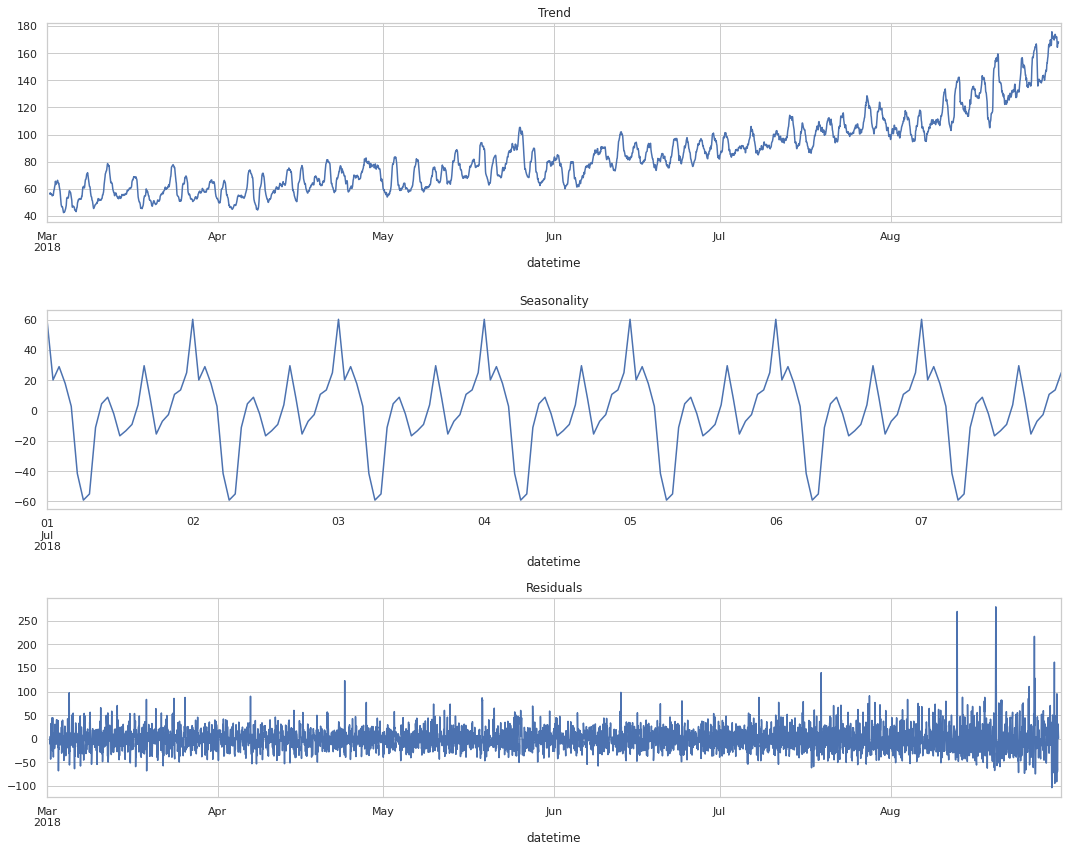

In [26]:
# тренд
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# сезонность
plt.subplot(312)
decomposed.seasonal['2018-07-01':'2018-07-07'].plot(ax=plt.gca())
plt.title('Seasonality')

# шум
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

По графику тренда наблюдается увеличение числа заказов с течением времени. На графике сезонности для случайной недели можно увидеть суточную закономерность, а именно: спад числа заказов ранним утром и пик заказов ночью. Вероятно это связано с тем, что в эти часы не работает общественный транспорт.

### Стационарность временного ряда

Временной ряд считается стационарным, если он не меняет своих статистических свойств с течением времени, а именно среднего значения и дисперсии.

In [27]:
# скользящее среднее значение
taxi['rolling_mean'] = taxi.rolling(168).mean()

# скользящее стандартное отклонение
taxi['rolling_std'] = taxi['num_orders'].rolling(168).std()

<AxesSubplot:xlabel='datetime'>

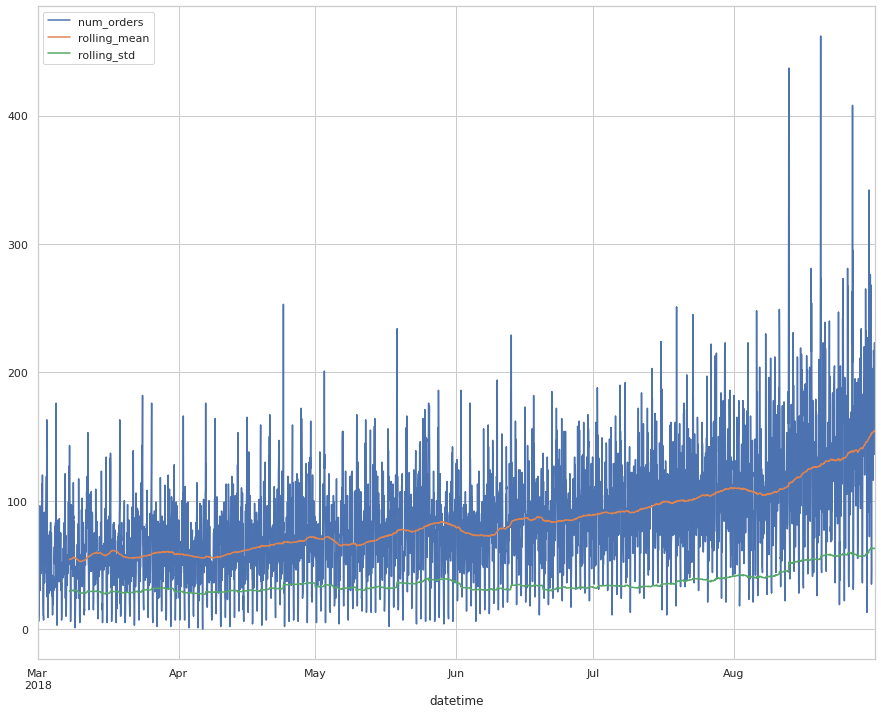

In [28]:
taxi.plot()

***Вывод:*** временной ряд нестационарный: меняется его среднее значение.

## Обучение

### Создание признаков

In [29]:
# для обучения создам копию датафрейма
taxi_fit = taxi.copy()

In [30]:
# функция для создания новых признаков
def create_features(df, rolling_mean_size, expanding_window_size, max_lag):
    
    # год
    df['year'] = df.index.year 
    
    # месяц
    df['month'] = df.index.month 
    
    # день
    df['day'] = df.index.day 
    
    # день недели
    df['dayofweek'] = df.index.dayofweek
    
    # скользящее среднее
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean() 
    
    # скользящее окно для расчета эксцессов
    df['kurtosis'] = df['num_orders'].shift().rolling(rolling_mean_size).apply(lambda x: kurtosis(x)) 
    
    # скользящее окно для расчета пиков
    df['peaks'] = df['num_orders'].shift().rolling(rolling_mean_size).apply(lambda x: len(find_peaks(x)[0]))
    
    # расширяющееся окно
    df['expanding_window'] = df['num_orders'].shift().expanding(expanding_window_size).mean()
    
    # разность временного ряда
    df['diff'] = df['num_orders'].shift().diff()
    
    # лаги
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

In [31]:
create_features(taxi_fit, 25, 3, 25)

На основе созданного признака дня недели, добавлю банарный признак, обозначающий, является ли день выходным:

In [32]:
def calc_dayoff(row):
    if row['dayofweek'] >= 5:
        return 1 # если день выходной
    else:
        return 0 # если день рабочий

In [33]:
taxi_fit['is_weekend'] = taxi_fit.apply(calc_dayoff, axis=1)

In [34]:
taxi_fit.head()

,num_orders,rolling_mean,rolling_std,year,month,day,dayofweek,kurtosis,peaks,expanding_window,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-03-01 01:00:00,85,NaN,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-03-01 02:00:00,71,NaN,NaN,2018,3,1,3,NaN,NaN,NaN,-39.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-03-01 03:00:00,66,NaN,NaN,2018,3,1,3,NaN,NaN,93.333333,-14.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-03-01 04:00:00,43,NaN,NaN,2018,3,1,3,NaN,NaN,86.500000,-5.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [35]:
# удаление пропущенных значений
taxi_fit = taxi_fit.dropna()

In [36]:
taxi_fit.head()

,num_orders,rolling_mean,rolling_std,year,month,day,dayofweek,kurtosis,peaks,expanding_window,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-07 23:00:00,94,59.00,29.596225,2018,3,7,2,-0.487303,8.0,53.988024,19.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,47.0,81.0,0
2018-03-08 00:00:00,143,59.52,29.899198,2018,3,8,3,-0.619843,9.0,54.226190,-33.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,47.0,0
2018-03-08 01:00:00,78,63.36,29.861067,2018,3,8,3,-0.619004,9.0,54.751479,49.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,0
2018-03-08 02:00:00,65,62.48,29.844555,2018,3,8,3,-0.422254,9.0,54.888235,-65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,0
2018-03-08 03:00:00,68,60.24,29.849664,2018,3,8,3,0.079143,9.0,54.947368,-13.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,0


### Разделение данных на выборки

In [37]:
train, test = train_test_split(taxi_fit, test_size=0.2, shuffle=False)

In [38]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

In [39]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [40]:
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-07 23:00:00 2018-07-27 13:00:00
2018-07-27 14:00:00 2018-08-31 23:00:00


In [41]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3399, 36)
(3399,)
(850, 36)
(850,)


In [42]:
features_train.head()

,rolling_mean,rolling_std,year,month,day,dayofweek,kurtosis,peaks,expanding_window,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-07 23:00:00,59.00,29.596225,2018,3,7,2,-0.487303,8.0,53.988024,19.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,47.0,81.0,0
2018-03-08 00:00:00,59.52,29.899198,2018,3,8,3,-0.619843,9.0,54.226190,-33.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,47.0,0
2018-03-08 01:00:00,63.36,29.861067,2018,3,8,3,-0.619004,9.0,54.751479,49.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,0
2018-03-08 02:00:00,62.48,29.844555,2018,3,8,3,-0.422254,9.0,54.888235,-65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,0
2018-03-08 03:00:00,60.24,29.849664,2018,3,8,3,0.079143,9.0,54.947368,-13.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,0


In [43]:
features_test.head()

,rolling_mean,rolling_std,year,month,day,dayofweek,kurtosis,peaks,expanding_window,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-27 14:00:00,107.36,37.837343,2018,7,27,4,1.046804,5.0,74.582165,26.0,144.0,118.0,110.0,149.0,139.0,89.0,44.0,78.0,64.0,109.0,131.0,161.0,108.0,222.0,117.0,105.0,90.0,69.0,71.0,84.0,113.0,142.0,104.0,53.0,70.0,0
2018-07-27 15:00:00,107.00,37.728118,2018,7,27,4,0.963281,6.0,74.578357,-83.0,61.0,144.0,118.0,110.0,149.0,139.0,89.0,44.0,78.0,64.0,109.0,131.0,161.0,108.0,222.0,117.0,105.0,90.0,69.0,71.0,84.0,113.0,142.0,104.0,53.0,0
2018-07-27 16:00:00,109.40,37.963333,2018,7,27,4,1.270234,6.0,74.589126,52.0,113.0,61.0,144.0,118.0,110.0,149.0,139.0,89.0,44.0,78.0,64.0,109.0,131.0,161.0,108.0,222.0,117.0,105.0,90.0,69.0,71.0,84.0,113.0,142.0,104.0,0
2018-07-27 17:00:00,111.72,38.086711,2018,7,27,4,0.656045,5.0,74.613617,49.0,162.0,113.0,61.0,144.0,118.0,110.0,149.0,139.0,89.0,44.0,78.0,64.0,109.0,131.0,161.0,108.0,222.0,117.0,105.0,90.0,69.0,71.0,84.0,113.0,142.0,0
2018-07-27 18:00:00,112.44,38.153912,2018,7,27,4,0.426154,6.0,74.637535,-2.0,160.0,162.0,113.0,61.0,144.0,118.0,110.0,149.0,139.0,89.0,44.0,78.0,64.0,109.0,131.0,161.0,108.0,222.0,117.0,105.0,90.0,69.0,71.0,84.0,113.0,0


### Подбор гиперпараметров

- ***Random Forest Regressor***

In [44]:
# def objective(trial):
    
#     param = {
#         "n_estimators": trial.suggest_int('n_estimators', 50, 800, log=True),
#         "max_depth": trial.suggest_int('max_depth', 3, 7),
#         "min_samples_split": trial.suggest_int('min_samples_split', 2, 4)
#     }
    
#     rfr = RandomForestRegressor(**param, random_state=SEED)
#     rfr.fit(features_train, target_train)
#     rmse = mean_squared_error(target_test, rfr.predict(features_test), squared=False)
#     return rmse

In [45]:
# %%time
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

In [46]:
# study.best_trial

**FrozenTrial(number=21, values=[45.15714153671379], datetime_start=datetime.datetime(2022, 11, 2, 13, 29, 56, 415509), datetime_complete=datetime.datetime(2022, 11, 2, 13, 29, 57, 949434), params={'n_estimators': 61, 'max_depth': 7, 'min_samples_split': 4}, distributions={'n_estimators': IntDistribution(high=800, log=True, low=50, step=1), 'max_depth': IntDistribution(high=7, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=21, state=TrialState.COMPLETE, value=None)**

- ***Gradient Boosting Regressor***

In [47]:
# def objective(trial):
    
#     param = {
#         "learning_rate": trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
#         "n_estimators": trial.suggest_int('n_estimators', 50, 800, log=True),
#         "max_depth": trial.suggest_int('max_depth', 3, 7),
#         "min_samples_split": trial.suggest_int('min_samples_split', 2, 4),
#         "min_samples_leaf": trial.suggest_int('min_samples_leaf', 1, 3),
#         'tol': trial.suggest_float('tol', 0.0001, 0.01, log=True)
#     }
    
#     gbr = GradientBoostingRegressor(**param, random_state=SEED)
#     gbr.fit(features_train, target_train)
#     rmse = mean_squared_error(target_test, gbr.predict(features_test), squared=False)
#     return rmse

In [48]:
# %%time
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

In [49]:
# study.best_trial

**FrozenTrial(number=87, values=[39.07376190757349], datetime_start=datetime.datetime(2022, 11, 2, 13, 59, 39, 840611), datetime_complete=datetime.datetime(2022, 11, 2, 14, 0, 2, 401147), params={'learning_rate': 0.03704975037608504, 'n_estimators': 632, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3, 'tol': 0.008210025050433068}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'n_estimators': IntDistribution(high=800, log=True, low=50, step=1), 'max_depth': IntDistribution(high=7, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=3, log=False, low=1, step=1), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=87, state=TrialState.COMPLETE, value=None)**

### Обучение моделей

- ***Random Forest Regressor***

In [50]:
tscv = TimeSeriesSplit()

In [51]:
rf_model = RandomForestRegressor(
    max_depth=7, 
    min_samples_split=4,  
    n_estimators=61, 
    random_state=SEED,
    n_jobs=-1
)

In [52]:
%%time

scores = cross_val_score(
    rf_model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error'
)
scores = abs(scores)
print('Средняя оценка качества модели: %.0f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 25 (2.72)
CPU times: user 4.4 s, sys: 21.4 ms, total: 4.43 s
Wall time: 4.43 s


**Средняя оценка качества модели: 25 (2.72)**

- ***Linear Regression***

In [53]:
lr_model = LinearRegression()

In [54]:
%%time

scores = cross_val_score(
    lr_model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error'
)
scores = abs(scores)
print('Средняя оценка качества модели: %.0f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 27 (1.89)
CPU times: user 181 ms, sys: 416 ms, total: 597 ms
Wall time: 550 ms


**Средняя оценка качества модели: 27 (1.89)**

- ***Gradient Boosting Regressor***

In [55]:
gbr_model = GradientBoostingRegressor(
    learning_rate=0.03704975037608504,
    n_estimators=632,
    max_depth=7,
    min_samples_split=3,
    min_samples_leaf=3,
    tol=0.008210025050433068,
    random_state=SEED
)

In [56]:
%%time

scores = cross_val_score(
    gbr_model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error'
)
scores = abs(scores)
print('Средняя оценка качества модели: %.0f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 25 (2.08)
CPU times: user 1min, sys: 120 ms, total: 1min 1s
Wall time: 1min 1s


**Средняя оценка качества модели: 25 (2.08)**

***Вывод:*** по результатам кросс-валидации лучшая оценка качества у модели `Gradient Boosting Regressor - 25`. Протестирую эту модель и выведу значение RMSE.

## Тестирование

In [57]:
gbr_model = GradientBoostingRegressor(
    learning_rate=0.03704975037608504,
    n_estimators=632,
    max_depth=7,
    min_samples_split=3,
    min_samples_leaf=3,
    tol=0.008210025050433068,
    random_state=SEED
)

gbr_model.fit(features_train, target_train)

GradientBoostingRegressor(learning_rate=0.03704975037608504, max_depth=7,
                          min_samples_leaf=3, min_samples_split=3,
                          n_estimators=632, random_state=123,
                          tol=0.008210025050433068)

In [62]:
%%time

predictions_test = gbr_model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test, squared=False)
print(f'RMSE для модели Gradient Boosting Regressor на тестовой выборке: %.0f' % (rmse))

RMSE для модели Gradient Boosting Regressor на тестовой выборке: 39
CPU times: user 20.1 ms, sys: 5 µs, total: 20.1 ms
Wall time: 18.7 ms


**Вывод:** RMSE для модели Gradient Boosting Regressor на тестовой выборке: 39.

In [63]:
predictions_test = pd.Series(predictions_test, index=features_test.index)

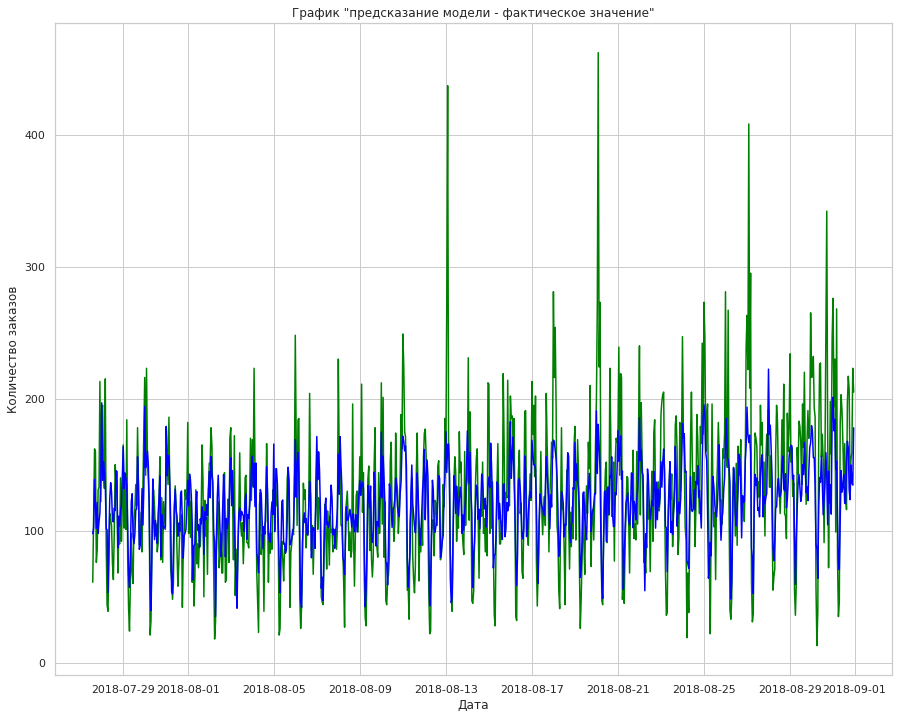

In [64]:
plt.plot(target_test, color = "green")
plt.plot(predictions_test, color = "blue")
 
plt.title("График \"предсказание модели - фактическое значение\"")
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.show()

## Вывод

Решена задача прогноза заказов такси на следующий час. Выполнен анализ временных рядов и обучена модель предсказания. Лучшей по результатам кросс-валидации стала модель **Gradient Boosting Regressor с метрикой RMSE на трейне = 25 и на тестовой выборке = 39.**